In [ ]:
from __future__ import division

import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

from svgpathtools import parse_path

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

### Setup

In [199]:
# directory & file hierarchy
proj_dir = os.path.abspath('../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))

if not os.path.exists(results_dir):
    os.makedirs(results_dir)  

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)  
    
## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))        
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/judithfan/semantic_parts/analysis/analysis_helpers.py'>

#### set up connection to mongo

In [139]:
#### set vars 
import pandas as pd
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['svgAnnotation']
coll = db['chairs4']

# which iteration name should we use?
iterationName = 'run0_chairs4'

### get some descriptive stats on our annotation data!

In [146]:
num_annotations = coll.find({'iterationName':iterationName}).count()
print 'We have {} annotations so far.'.format(num_annotations)

We have 1224 annotations so far.


#### build up annotation data csv

In [147]:
## TODO remember to ignore researcher worker ID's in our dataset
jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV','A1MMCS8S8CTWKS']
hawkrobe = ['A1BOIDKD33QSDK']
megsano = ['A1DVQQLVZR7W6I']
kmukherjee = ['A1WU4IHJNQGVAY']
researchers = jefan + hawkrobe + megsano + kmukherjee

In [148]:
## TODO use a helper function to get complete and valid HITs 

In [149]:
## categories that are in play
main_category = 'chair'
dataset = 'chairs4'

In [150]:
## get list of unique_assignments
unique_assignments = coll.find({'iterationName':iterationName}).distinct('aID')

### initialize a bunch of stuff
orig_gameID = [] # the gameID from which this sketch was sourced
orig_trial_num = [] # the trialnum in the original game from which this sketch was sourced -- 
sketch_id = [] # concatenation of orig_gameID and orig_trial_num -- 
assignmentID = [] # the session in which this annotation was collected -- 
annotation_id = [] # the unique ID for each annotation trial (different for each session the same sketch appears in)
category = [] # e.g., "chair"
target = [] # e.g., "inlay"
condition = [] # e.g., "closer" vs. "further" or "repeated" vs. "control
trial_num = []
time_submitted = [] # when the participant clicked "next sketch"
time_labeled = [] # unique to each spline labeled
time_clicked = [] # when this spline was clicked/selected
num_strokes_in_sketch = [] # how many strokes in this sketch
num_splines_in_sketch = [] # how many spline elements in this sketch
stroke_num = [] # which stroke number this labeled spline came from
cumulative_spline_num = [] # spline index in the cumulative spline sequence for the entire sketch
within_stroke_spline_num = [] # spline index for the current stroke
label = [] # the label provided by the participant
spline_svg_string = [] # the svg spline string that earned this label
sketch_svg_string = [] # the entire svg string correponding to this sketch
annotation_flag = [] # this is True if all splines were labeled as the same thing

## loop through all the unique assignments that have submitted things
for this_assignment, aID in enumerate(unique_assignments):
    if this_assignment%50==0:
        print 'Analyzing sketches from assignment {} of {}  ...'.format(this_assignment, len(unique_assignments))

    ### get all the sketch recs for this assignment
    sketch_recs = coll.find({'$and': [{'iterationName':iterationName}, {'aID':aID}]}).sort('time')

    try:

        for sketch_ind,sketch in enumerate(sketch_recs):
            ## get annotations embedded within record
            annotations_string = sketch['annotations']  
            ## convert to json dictionary
            _annotations_dict = json.loads(annotations_string)   
            annotations_dict = _annotations_dict[0][main_category]
            num_splines = len(annotations_dict)
            for annotation in annotations_dict:
                assert sketch['numSplines']==num_splines                
                ## get spline-level metadata
                label.append(annotation['label'])
                stroke_num.append(annotation['strokeNum'])
                spline_svg_string.append(annotation['svgString'])
                cumulative_spline_num.append(annotation['cumulativeSplineNum'])
                within_stroke_spline_num.append(annotation['withinStrokeSplineNum'])
                time_clicked.append(annotation['timeClicked'])
                time_labeled.append(annotation['timeLabeled'])
                ## get sketch-level metadata
                orig_gameID.append(sketch['originalGameID'])   
                orig_trial_num.append(sketch['originalTrialNum'])
                sketch_id.append('{}_{}'.format(sketch['originalGameID'],sketch['originalTrialNum']))
                annotation_id.append('{}_{}_{}'.format(sketch['originalGameID'],sketch['originalTrialNum'],sketch['aID']))
                assignmentID.append(sketch['aID'])
                category.append(sketch['category'])
                target.append(sketch['target'])
                condition.append(sketch['condition'])
                time_submitted.append(sketch['time'])
                trial_num.append(sketch['trialNum'])
                num_splines_in_sketch.append(sketch['numSplines'])
                num_strokes_in_sketch.append(sketch['numStrokes'])
                sketch_svg_string.append(sketch['svg'])
                annotation_flag.append(sketch['sameAnnotflag'])
                
    except AssertionError:
        print 'There were unequal numbers for sketch["numSplines"] vs. num_splines for sketch {} from {}'.\
                format(sketch['trialNum'], sketch['aID'])


Analyzing sketches from assignment 0 of 134  ...
Analyzing sketches from assignment 50 of 134  ...
There were unequal numbers for sketch["numSplines"] vs. num_splines for sketch 0 from 336YQZE83WS2132FW9VT3OWTC0UM5V
There were unequal numbers for sketch["numSplines"] vs. num_splines for sketch 1 from 3AMYWKA6YC0MKAN5E8KBNYZY3VL6OB
There were unequal numbers for sketch["numSplines"] vs. num_splines for sketch 3 from 3CTOC39K384RNZADH5XYLGI8ZCV7JS
Analyzing sketches from assignment 100 of 134  ...
There were unequal numbers for sketch["numSplines"] vs. num_splines for sketch 6 from 3GNA64GUZFITMI07O22AKXGYM25Q52


In [151]:
## make group data csv 
D = pd.DataFrame([orig_gameID, orig_trial_num, sketch_id, category, assignmentID,  target, \
                  annotation_id, condition, trial_num, time_submitted,\
                 time_labeled, time_clicked, num_strokes_in_sketch, num_splines_in_sketch,\
                 stroke_num, cumulative_spline_num, within_stroke_spline_num, label,\
                 spline_svg_string, sketch_svg_string])
D = D.transpose()
D.columns = ['orig_gameID', 'orig_trial_num', 'sketch_id', 'category', 'assignmentID', 'target',\
             'annotation_id', 'condition', 'trial_num', 'time_submitted',\
             'time_labeled', 'time_clicked', 'num_strokes_in_sketch', 'num_splines_in_sketch',\
             'stroke_num', 'cumulative_spline_num', 'within_stroke_spline_num', 'label',\
             'spline_svg_string', 'sketch_svg_string']

print 'Annotations dataframe contains {} rows and {} columns.'.format(D.shape[0],D.shape[1])

Annotations dataframe contains 28344 rows and 20 columns.


In [152]:
## save out csv to results dir
D.to_csv(os.path.join(results_dir,'svg_annotations_{}.csv'.format(dataset)))

#### get descriptive stats on annotation data

In [44]:
## Some starting questions about sketchpad_basic dataset

## Annotation task
## How consistent are annotators for the same object? Inter-rater reliability

## Content
## What does the part distribution look like for each object? Presence/absence.
## How does the part distribution differ between contexts, matched by object?

## Contenty Style
## Here we might use arc length as a measure of how much was expended for each part.
## How much arc length is spent on each part 
## Is the entropy of the part distribution (measuring arc length) different for close trials than far trials?

## Dynamics
## Are people drawing each part "in succession?" (Do people plan & execute their drawings in terms of parts?)
## Are people starting out producing longer strokes, than shorter strokes? Look at time series within 
## sketch for the arc lengths of strokes produced .... 

### Make visualizations of dataset

##### How many sketches do we have annotated?

In [153]:
unique_sketches = np.unique(D['sketch_id'].values)
print 'We have {} unique sketches.'.format(len(unique_sketches))

We have 370 unique sketches.


#### Number of times each sketch has been annotated

Text(0,0.5,'number of sketches')

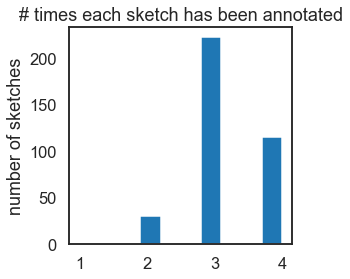

In [154]:
## get number of times it has been annotated
num_times_annotated = []
for this_sketch_id in unique_sketches:
    num_times_annotated.append(D[D['sketch_id']==this_sketch_id]['assignmentID'].nunique())
    
## make a histogram
sns.set_context('talk')
plt.figure(figsize=(4,4))
h = plt.hist(num_times_annotated)
plt.title('# times each sketch has been annotated')
plt.ylabel('number of sketches')

##### check to make sure that for each sketch, you have a unique number of splines associated with it

In [179]:
unique_sketches = np.unique(D['sketch_id'].values)
for this_sketch in unique_sketches:
    assert len(np.unique(D[D['sketch_id']==this_sketch]['num_splines_in_sketch'].values))==1

##### How long do sketches take to annotate? Do more complex sketches (i.e., those consisting of more splines) take longer to annotate? [Sanity check]

In [186]:
#### first, we will get the amount of time taken to annotate each sketch
unique_annotation_trials = np.unique(D['annotation_id'].values)

In [212]:
## get annotation time for each annotation trial
annotation_time = []
spline_number_in_sketch = []

for this_annotation_trial in unique_annotation_trials:
    earliest_click = float(np.min(D[D['annotation_id']==this_annotation_trial]['time_clicked']))
    ## all of the splines were submitted at the same time, so time_submitted should be identical for all splines in an annotation trial
    assert len(np.unique(D[D['annotation_id']==this_annotation_trial]['time_submitted'].values))==1
    final_submission = np.unique(D[D['annotation_id']==this_annotation_trial]['time_submitted'].values)[0]
    annotation_time.append(final_submission-earliest_click)        
    if np.isnan(final_submission) or np.isnan(earliest_click):
        print 'One of these timestamps is a NaN. Probably means that the participant skipped this trial:'
        print this_annotation_trial
        print 'final_submission: {}, earliest_click: {}'.format(final_submission, earliest_click)
    #### then we will extract how "complex" each sketch i
    assert len(np.unique(D[D['annotation_id']==this_annotation_trial]['num_splines_in_sketch'].values))==1    
    spline_number_in_sketch.append(np.unique(D[D['annotation_id']==this_annotation_trial]['num_splines_in_sketch'])[0])
    

One of these timestamps is a NaN. Probably means that the participant skipped this trial:
5707-49e9e7c8-5fe1-4469-9905-4ba89ccde7dd_17_34QN5IT0T05OL7EA52FYHBZ7BO880O
final_submission: 1.53368507963e+12, earliest_click: nan


In [223]:
## convert annotation time to seconds
annotation_time_seconds = np.array(annotation_time)/1000

## make dataframe with annotation time and spline number
unique_annotation_trials, spline_number_in_sketch, annotation_time_seconds = map(list, [unique_annotation_trials, spline_number_in_sketch, annotation_time_seconds])
T = pd.DataFrame([unique_annotation_trials,spline_number_in_sketch,annotation_time_seconds])
T = T.transpose()
T.columns = ['annotation_trial','spline_number_in_sketch','annotation_time']

## some preprocessing of T
reload(h)

## make numeric types
T = h.convert_numeric(T,'spline_number_in_sketch')
T = h.convert_numeric(T,'annotation_time')

## also remove the skipped trial where annotation time is a NaN
T = T[~np.isnan(T['annotation_time'])]

(0, 300)

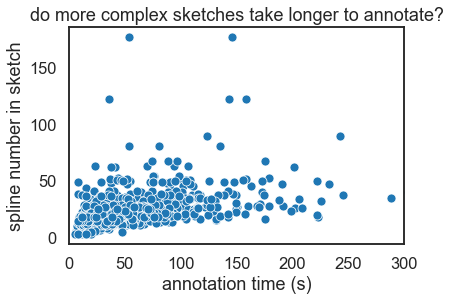

In [224]:
## make scatterplot of relationship between annotation time and spline number
sns.scatterplot(x='annotation_time',
                y='spline_number_in_sketch',
                data=T)
plt.ylabel('spline number in sketch')
plt.xlabel('annotation time (s)')
plt.title('do more complex sketches take longer to annotate?')
plt.xlim(0,60*5) ## 5 minute cutoff ...

In [228]:
r, p = stats.spearmanr(T['annotation_time'],T['spline_number_in_sketch'])
print 'Spearman correlation between annotation time and spline number in sketch' 
print 'r = {}, p = {}'.format(r,p)

Spearman correlation between annotation time and spline number in sketch
r = 0.504308893457, p = 5.78840524155e-78


##### Make histogram of part word occurrence distribution

In [283]:
## get the list of unique labels applied to chairs
unique_labels = np.unique(D.label.values)

## some deborkification of the unique label list
unique_labels = [i for i in unique_labels if i is not None]
unique_labels = [i for i in unique_labels if len(i)<900]

In [305]:
print 'After some light deborkficiation, there are {} unique part labels in our dataset.'.format(len(unique_labels))

After some light deborkficiation, there are 93 unique part labels in our dataset.


In [ ]:
## create a dataframe that is [num_sketches x num_labels] where each cell is incremented by 1
## when that part word appears as an annotation to that sketch

In [307]:
unique_labels = np.array(unique_labels)

In [ ]:
unique_labels

In [282]:
for this_sketch in unique_sketches[:2]:
    print this_sketch
    DS = D[D['sketch_id']==this_sketch]
    annotation_ids = np.unique(DS['annotation_id'].values)    
    for this_annotation in annotation_ids:
        DSA = DS[(DS['sketch_id']==this_sketch) & (DS['annotation_id']==this_annotation)]
        print np.unique(DSA.label.values)

0075-ad14e50c-f328-451b-82b0-2a7d3b392127_15
[u'backrest' u'seat']
[u'backrest' u'seat']
[u'backrest' u'seat']
0075-ad14e50c-f328-451b-82b0-2a7d3b392127_24
[u'backrest' u'seat']
[u'armrest' u'backrest' u'leg' u'seat']
[u'backrest' u'seat']


array(['0075-ad14e50c-f328-451b-82b0-2a7d3b392127_24_34QN5IT0T05OL7EA52FYHBZ7BO880O',
       '0075-ad14e50c-f328-451b-82b0-2a7d3b392127_24_3NXNZ5RS1BB2HNX4VT6LWM4537J79X',
       '0075-ad14e50c-f328-451b-82b0-2a7d3b392127_24_3QAPZX2QN5RDZSCLPL6X7KM4PM602Z'],
      dtype=object)

In [274]:
from collections import Counter
dict(this_sketch=dict(Counter(_D.label.values)))

{'this_sketch': {u'armrest': 2, u'backrest': 13, u'leg': 2, u'seat': 16}}

In [261]:
dict(this_sketch,np.unique(_D.label.values))

ValueError: dictionary update sequence element #0 has length 44; 2 is required

In [268]:
dict(this_sketch=set(np.unique(_D.label.values)))

{'this_sketch': {u'armrest', u'backrest', u'leg', u'seat'}}

In [254]:
len(unique_labels)

95

In [256]:
unique_sketches[0]

'0075-ad14e50c-f328-451b-82b0-2a7d3b392127_15'

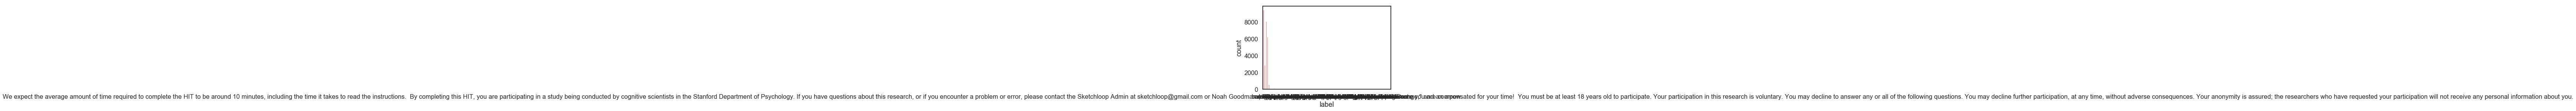

In [244]:
sns.countplot(x='label', data=D)

##### Build a dataframe that vectorizes each annotation trial into the presence/absence of a part label [num_annotation_trials x num_words_in_lexicon]

##### Build a dataframe that vectorizes each spline into the count of each part label [num_splines_in_dataset x num_words_in_lexicon]